In [1]:
import numpy as np
from numba import njit, jit, njit, prange, float64, int32, typeof
from numba.experimental import jitclass
from quantecon.optimize.scalar_maximization import brent_max
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from interpolation import interp

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

Conceptually: an equilibrium, as defined above, such that $r_t$ and the distribution $Γ_t(a,ε)$ do not depend
on $t$. That is, the distribution of people over asset holdings and endowments looks the same every period,
but individuals move around within it. E.g., the number of people with $ε = ε_h$ and with $a < 2$ is the same
every period, even though each consumer only belongs to this group now and then.

Formally: we use recursive methods. The consumer problem is:

$$ V_s(a)= max_{a' ∈[\phi,ε_s +a(1+r)]} [u(ε_s+(1+r)a−a′)+β (π_s V_h(a′)+(1−π_s)V_l(a′))] $$ for all $s$ and $a$.

Decision rule: the problem delivers optimal asset holdings $a′ = g_s (a)$ satisfying, for all $s$ and $a$,

$$g_s (a) = argmax_{a′} [u(ε_s +(1+r)a−a′)+β(π_s V_h(a′) + (1 − π_s )V_l (a′)) ]$$

s.t. $a′ ∈ [\phi, (ε_s + a)(1+r)]$.

Asset-market clears, more precisely:

$$ \int_s \int_a g_s(a) \Gamma(a,s) = 0 $$

In [2]:
para_Household = [
                 ('beta',float64),
                 ('r',float64),
                 ('phi',float64),
                 ('shocks',float64[:]),
                 ('w',float64),
                 ('PI',float64[:,::1]),
                 ('gamma',float64),
                 ('grid',float64[:])]


@jitclass(para_Household)
class Household(object):
    def __init__(self,
                 a_min = -3,
                 a_max = 18,
                 N = 100,
                 beta = 1.03**(-1/12),
                 r = 0.00246,
                 phi = -1,
                 shocks = np.array([0.5,1]),
                 w = 5,
                 PI = np.array([[0.4,0.6],[0.6,0.4]]),
                 gamma=2):
        self.beta,self.r,self.phi,self.shocks,self.w,self.PI,self.gamma = beta,r,phi,shocks,w,PI,gamma
        self.grid = np.linspace(a_min,a_max,N)
    
    def u(self,c):
        if c > 0:
            if self.gamma != 1:
                return c**(1-self.gamma)/(1-self.gamma)
            else:
                return np.log(c)
        else:
            return -np.infty

In [3]:
@jit
def state_action_value(aprime,a,s_index,v_array,hh):
    v = lambda x: [interp(hh.grid,v_array[k],x) for k in range(len(hh.shocks))]
    shock = hh.shocks[s_index]
    c = hh.w*shock+(1+hh.r)*a-aprime
    V_next = np.asarray(v(aprime))
    
    V = hh.u(c)+hh.beta*np.dot(hh.PI[s_index],V_next)
    return V

@njit
def T(v,hh):
    v_new =  np.empty_like(v)
    v_greedy = np.empty_like(v)
    phi =hh.phi
    
    for j in range(len(hh.shocks)):
        for i in range(len(hh.grid)):
            a = hh.grid[i]
            a_max = hh.w*hh.shocks[j]+(1+hh.r)*a
            result = brent_max(state_action_value,phi,a_max-1e-6,args=(a,j,v,hh))
            v_greedy[j][i], v_new[j][i] = result[0], result[1]
            
    return v_greedy, v_new

In [4]:
def solve_model(v,hh,
                tol=1e-3,
                max_iter=10000,
                verbose=True,
                print_skip=100):

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_greedy, v_new = T(v, hh)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new

In [6]:
hh = Household()
v = np.zeros((2,len(hh.grid)))
v_greedy, v_new = solve_model(v,hh)

Error at iteration 100 is 0.20937331882974775.
Error at iteration 200 is 0.16353912312673913.
Error at iteration 300 is 0.1278284014580322.
Error at iteration 400 is 0.09991935827790144.
Error at iteration 500 is 0.07810390039816184.
Error at iteration 600 is 0.0610514310296395.
Error at iteration 700 is 0.0477220379008827.
Error at iteration 800 is 0.03730285782880571.
Error at iteration 900 is 0.029158504157933862.
Error at iteration 1000 is 0.02279231143424454.
Error at iteration 1100 is 0.01781605432702804.
Error at iteration 1200 is 0.01392626368814831.
Error at iteration 1300 is 0.010885735041696876.
Error at iteration 1400 is 0.008509046612402926.
Error at iteration 1500 is 0.0066512611414708545.
Error at iteration 1600 is 0.005199088142830988.
Error at iteration 1700 is 0.004063967931529078.
Error at iteration 1800 is 0.003176679568625218.
Error at iteration 1900 is 0.002483113739657483.
Error at iteration 2000 is 0.001940974108009641.
Error at iteration 2100 is 0.0015172002408

In [106]:
v_greedy

array([[-0.99999366, -0.99999427, -0.99999567, -0.99999398, -0.99999595,
        -0.9999945 , -0.99999347, -0.99999569, -0.99999451, -0.99999367,
        -0.9999961 , -0.99999587, -0.89396465, -0.8224615 , -0.66666601,
        -0.51349607, -0.3671399 , -0.19617685, -0.03030131,  0.17257705,
         0.35483723,  0.53909937,  0.72948568,  0.91262828,  1.10700881,
         1.30255913,  1.49994088,  1.6970529 ,  1.89516257,  2.09584166,
         2.30303163,  2.5098286 ,  2.71182724,  2.91404361,  3.11684953,
         3.3206947 ,  3.52480314,  3.72943143,  3.93429385,  4.13950403,
         4.34517567,  4.55107497,  4.75722909,  4.96357104,  5.17010736,
         5.37686922,  5.58379349,  5.79084942,  5.99804778,  6.20536127,
         6.41279174,  6.62032324,  6.82792041,  7.03555416,  7.24329696,
         7.45110539,  7.65896176,  7.86685312,  8.07476099,  8.28268869,
         8.4906436 ,  8.69860101,  8.90655663,  9.11449477,  9.32241815,
         9.53031989,  9.73818225,  9.94598799, 10.1

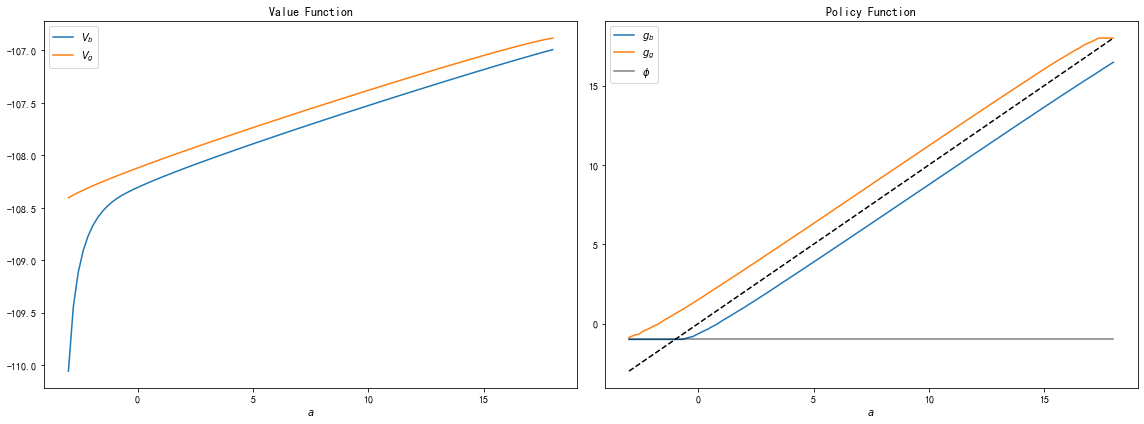

In [7]:
fig, ax = plt.subplots(1,2,figsize = (16,6))
agrid = hh.grid
# Plot 1: Value Functions
ax[0].set_title("Value Function")
ax[0].plot(agrid, v_new[0], label =r'$V_b$')
ax[0].plot(agrid, v_new[1], label =r'$V_g$')
ax[0].set_xlabel(r'$a$')
ax[0].legend()

# Plot 2: Policy Functions
ax[1].set_title("Policy Function")
ax[1].plot(agrid, v_greedy[0], label =r'$g_b$')
ax[1].plot(agrid, v_greedy[1], label =r'$g_g$')
ax[1].plot(agrid, agrid, color = 'black', linestyle = '--')
ax[1].plot(agrid, np.ones(len(agrid))*hh.phi, label = r'$\phi$', color = 'black', alpha = 0.5)
ax[1].set_xlabel(r'$a$')
ax[1].legend()
fig.tight_layout()
plt.show()

Now that we have solved the household problem and got $g(a,z)$, we can compute the stationary distribution of assets:

Recall the stationary distribution is:
$$ \Gamma(\hat{a},\hat{y}) = P(a\leq\hat{a},y=\hat{y}) $$.


Continuum of households makes the wealth distribution a continuous function and therefore an infinite-dimension object
in the state space. Need approximation!

If $g$ is monotonic, then the invariante distribution can be characterized as:

$$\Gamma(a',{y'}) = \sum \limits_{y\in \mathcal{Y}} \pi(y'|y) \Gamma(g^{-1}(a',y),{y})$$

There are several methods that approximate the stationary distribution:

1. Splines interpolation + inversion of $g$ + interation
    **Approach**: approximate $\Gamma$ with splines and iterate on the the law of motion above until convergence.

    1. We need a grid $A$ of interpolation nodes in the interval. This needs to be much more finer than for policy.

    2. Have an initial guess $\Gamma_0$. Uniform distribution is fine.

    3. Spline approximation of $g^{-1}$ and $\Gamma_0$

    4. Iterate

    In the Huggett model with a domain where binding borrowing constraints case, we cannot use this approach since $g$ is not strictly montotonic.

2. Discretization of invariant density function $\phi(a,y)$ + iteration

3. Turn $g$ into a transition matrix and compute the eigenvector associated with the unitary eigenvalue.
    $\phi(a,y) = M \phi(a,y)$, so $(M-I)\phi(a,y)=0$

4. Monte Carlo simulation until markov chain has converged to stationary distribution

In [8]:
gb = savgol_filter(v_greedy[0], 51, 3)
gg = savgol_filter(v_greedy[1], 51, 3)

gb = interp1d(agrid, gb, kind='linear', fill_value='extrapolate')
gg = interp1d(agrid, gg, kind='linear', fill_value='extrapolate')
N = 100
a_vals = np.linspace(-3, 18, N)
a1b_star = gb(a_vals)
a1g_star = gg(a_vals)

F = interp1d(a_vals,a_vals, kind = 'next', fill_value = 18.0, bounds_error=False)
a1gd_star = F(gg(a_vals))
a1bd_star = F(gb(a_vals))

Tg = np.zeros([N,N])
Tb = np.zeros([N,N])
ixg = np.where(a_vals==a1bd_star[20])
print(a_vals[10],a_vals[ixg], ixg)

-0.8787878787878789 [0.39393939] (array([16], dtype=int64),)


In [24]:
a1gd_star

array([-0.87878788, -0.66666667, -0.45454545, -0.45454545, -0.24242424,
       -0.03030303,  0.18181818,  0.39393939,  0.39393939,  0.60606061,
        0.81818182,  1.03030303,  1.24242424,  1.45454545,  1.66666667,
        1.87878788,  1.87878788,  2.09090909,  2.3030303 ,  2.51515152,
        2.72727273,  2.93939394,  3.15151515,  3.36363636,  3.57575758,
        3.78787879,  4.        ,  4.21212121,  4.42424242,  4.63636364,
        4.84848485,  5.06060606,  5.27272727,  5.48484848,  5.6969697 ,
        5.90909091,  6.12121212,  6.33333333,  6.54545455,  6.75757576,
        6.96969697,  7.18181818,  7.39393939,  7.60606061,  7.81818182,
        8.03030303,  8.24242424,  8.24242424,  8.45454545,  8.66666667,
        8.87878788,  9.09090909,  9.3030303 ,  9.51515152,  9.72727273,
        9.93939394, 10.15151515, 10.36363636, 10.57575758, 10.78787879,
       11.        , 11.21212121, 11.42424242, 11.63636364, 11.84848485,
       12.06060606, 12.27272727, 12.48484848, 12.6969697 , 12.90

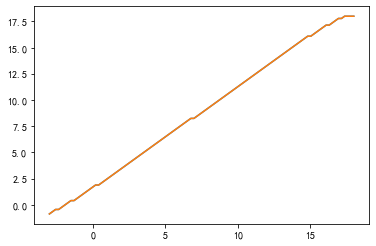

In [31]:
# plt.plot(hh.grid,a1g_star)
plt.plot(hh.grid,F(a1g_star))
plt.plot(hh.grid,a1gd_star)

In [25]:
a1g_star

array([-0.95190172, -0.79592206, -0.63677919, -0.47456931, -0.30938864,
       -0.14133338,  0.02950025,  0.20301604,  0.37911779,  0.55770928,
        0.7386943 ,  0.92197664,  1.1074601 ,  1.29504846,  1.48464551,
        1.67615505,  1.86948086,  2.06452672,  2.26119645,  2.45939381,
        2.6590226 ,  2.85998661,  3.06218964,  3.26553546,  3.46992788,
        3.67527068,  3.88266542,  4.09057571,  4.29663659,  4.50444359,
        4.71160143,  4.91879929,  5.12515117,  5.33264375,  5.54021452,
        5.74781838,  5.95556107,  6.16300553,  6.37051052,  6.57806042,
        6.78566986,  6.99325921,  7.2011459 ,  7.40921649,  7.6173512 ,
        7.82553684,  8.03376595,  8.2420166 ,  8.45028119,  8.65857083,
        8.86686439,  9.07515529,  9.28344899,  9.49174882,  9.70004227,
        9.9083064 , 10.11652383, 10.32474143, 10.5327455 , 10.74055892,
       10.9483811 , 11.15617051, 11.36389983, 11.57181528, 11.7798566 ,
       11.98785905, 12.19576374, 12.40404882, 12.61151344, 12.81

In [9]:
@njit
def populate_M(a_vals, N, a1gd_star, a1bd_star, a1g_star, a1b_star, Tb, Tg, PI):
    for i in range(N):
        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        Tg[i,ixg-1] = 1-Tg[i,ixg]

        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            Tb[i,ixb-1] = 1-Tb[i,ixb]
    P = PI
    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
    return M



In [ ]:
# M = populate_M(a_vals, N, a1gd_star, a1bd_star, a1g_star, a1b_star, Tb, Tg, hh.PI)
M = populate_M(hh.grid, N,v_greedy[1] , v_greedy[0], v_greedy[1], v_greedy[0], Tb, Tg, hh.PI)
#print(M[100,:])
from scipy.sparse import csr_matrix
M = csr_matrix(M)

M2 = csr_matrix.transpose(M)
import scipy.sparse.linalg as sla

D, V = sla.eigs(M2, k=1, sigma = 1.0)
print(D)
V = np.real(V[:,0])/sum(np.real(V[:,0]))
V[V<0]=0
V = np.real(V)/sum(np.real(V))
#print(V[199])
dist = V[0:N]+V[N:]

plt.plot(a_vals, np.cumsum(dist))

Total net assets is: 9.071582450846835


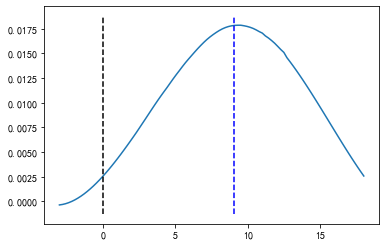

In [120]:
dist_c = savgol_filter(dist, 51, 3)
mean_a = np.dot(a_vals.T,dist)
print('Total net assets is:', mean_a)
plt.plot(a_vals[:], dist_c)
ylim = plt.gca().get_ylim()
plt.plot(np.zeros(30), np.linspace(ylim[0],ylim[1], 30),'k--')
plt.plot(np.ones(30)*mean_a, np.linspace(ylim[0],ylim[1], 30),'b--')
plt.show()